# Antecedent Precipitation Index

The API is a well-known, parsimonious, recursive model for predicting soil moisture solely based on precipitation records. The API is most commonly implemented using daily precipitation records, but it is possible to work at finer temporal scales if both precipitation (model input) and soil moisture (for validation purposes) are available. The equation describing the simples version of the model is:

$$API_{t} = \gamma \; API_{t-1} + P_t$$


$API_t$: Soil water content at time $t$ (today)

$API_{t-1}$: Soil water content at time $t-1$ (yesterday)

$\gamma$: Loss coefficient. Range between 0 and 1

$P_t$: Precipitation at time $t$ (today)

In its simplest version, the API has only one parameter, the loss parameter, which is often represented by $\alpha$ or $\gamma$. The loss paramter modulates the rate at which soil moisture decreases over time. Because of the recursive nature of the model the soil mositure depletion adopts an exponential shape. The loss parameter is a lumped paramter, which means accounts for the effect of multiple variables contributing to the rate of soil moisture loss. The loss paramter accounts for  atmospheric evaporative demand, soil water redistribution and drainage, plant water uptake, sub-surface runoff, and any other factor contributing to the loss of soil water in the considered depth. 

The API has the same units as precipitation (e.g. millimeters, inches). The API is a recursive model that requires knolwedge of the **initial conditions** or initial state of the soil (i.e. the amount of soil water at the beginning of the simulation). In other words, we need a starting point to work out the magic with the model.This value can be obtained from observations, approximated based on knoledge of recent (or the lack of) rainfall events, or simply guessed.


In the simplest version of the model, the loss coefficient can be considered constant, but this assumption often leads to under/over estimation since the amount of soil water that is lost each day is subtantially different along the year. An improved version would be to capture seasonal changes using a proxy variable such as air temperature, vapor pressure deficit, or even something as simple as the day of the year. The latter alternative will not capture intra-season variability and will also ignore the effects of the soil and actively growing vegetation, but it should improve the model, it just won't be perfect. The following model describes a time variant loss coefficient:

$$\gamma = C + A \sin \bigg(\omega t  + \phi\bigg) $$

$\gamma$ = Loss coefficient. Dimnesionless. Fraction of soil water remaining from the previous time step. For instance, if we are working with daily data and $\gamma$ is 0.95, this means that today we have in the soil 95% of the water that we had yesterday. In other words, we are losing 5% of the soil water per day. Note that this a fracton from the previous time step, meaning that the loss is becoming smaller with each time step becuse the previous time step is also becoming smaller.

$C$ = Annual average value for the loss coefficient

$A$ = Annual amplitude for the loss coefficient. We will assume that the wave is symmetric and that the highest value of the wave is around 1, which means that there is no water loss (today's soil water is equal to yesterday's soil water). A value of $\gamma = 1$ would typically occur around the day of the lowest atmopsheric demand (e.g. coldest day of the year). Now we rarely reach a perfect value of 1. So, in this example we will use 0.99, meaning that we are assuming a minimum loss of 1%.

$t$ = Day of the year

$\omega$ = Angular frequency = $2 \pi f$

$f$ = Frequency = $\frac{DOY}{Period}$

$Period$ = 365 days

$\phi$ = Phase or shift constant = $\frac{\pi}{2} + \omega t_o$. The term $\frac{\pi}{2}$ is added to align the sine wave, so that $t_o$ has a clear physical meaning. You can change this term to match $t_o$ with the day of highest atmospheric demand rather than the lowest.

$t_o$ = Day of the year of largest $\gamma$ value (lowest loss, day of lowest atmospheric demand)



In [250]:
# Import modules
import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [251]:
# Navigate to file directory
os.chdir("/Users/andrespatrignani/Dropbox/Teaching/Scientific programming/pynotes/datasets/")


## Load data

For this example we will use data from the Bedford station, IN obtained from the US Climate Reference Network. The data spans the period 3-Oct-2007 to 24-Oct-2017. There is no particular reason why we are exploring this dataset and this period. It's just some data that I gather and compiled from the [USCRN website](https://www.ncdc.noaa.gov/crn/).

In [252]:
# Load data from .CSV file
df = pd.read_csv('IN_Bedford_5_WNW.txt')


In [253]:
# Let's examine the first few entries
df.head(3)

,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,63898,20071003,1.302,-86.57,38.89,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,63898,20071004,1.302,-86.57,38.89,28.9,14.8,21.9,21.9,0.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
2,63898,20071005,1.302,-86.57,38.89,29.3,19.0,24.2,23.5,0.0,...,-99.0,-99.0,-99.0,-99.0,-99.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [254]:
# Let's examine the last few values of the dataset
df.tail(3)

,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
3652,63898,20171002,2.422,-86.57,38.89,26.2,11.4,18.8,18.7,0.0,...,0.166,0.199,0.220,0.461,0.339,17.3,17.5,17.6,20.2,19.2
3653,63898,20171003,2.422,-86.57,38.89,27.4,15.1,21.2,20.9,0.0,...,0.164,0.198,0.219,0.461,0.338,18.3,18.2,18.0,20.1,19.1
3654,63898,20171004,2.422,-86.57,38.89,26.8,18.7,22.8,22.1,0.0,...,0.163,0.198,0.219,0.460,0.335,19.3,19.1,18.7,20.2,18.9


In [255]:
# Replace missing values (-9999 and -99)
# Replace NaN values in precipitation by zeros
df = df.replace(-9999,np.nan)
df = df.replace(-99,np.nan)
df['P_DAILY_CALC'] = df['P_DAILY_CALC'].replace(np.nan,0)
df.head(5)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,63898,20071003,1.302,-86.57,38.89,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63898,20071004,1.302,-86.57,38.89,28.9,14.8,21.9,21.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63898,20071005,1.302,-86.57,38.89,29.3,19.0,24.2,23.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63898,20071006,1.302,-86.57,38.89,30.2,19.5,24.9,24.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63898,20071007,1.302,-86.57,38.89,31.4,17.9,24.6,24.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [256]:
# Convert date to Pandas datetime format
df['LST_DATE'] = pd.to_datetime(df['LST_DATE'].apply(str))
df.head(5)


,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,P_DAILY_CALC,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,63898,2007-10-03,1.302,-86.57,38.89,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,63898,2007-10-04,1.302,-86.57,38.89,28.9,14.8,21.9,21.9,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,63898,2007-10-05,1.302,-86.57,38.89,29.3,19.0,24.2,23.5,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,63898,2007-10-06,1.302,-86.57,38.89,30.2,19.5,24.9,24.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63898,2007-10-07,1.302,-86.57,38.89,31.4,17.9,24.6,24.4,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


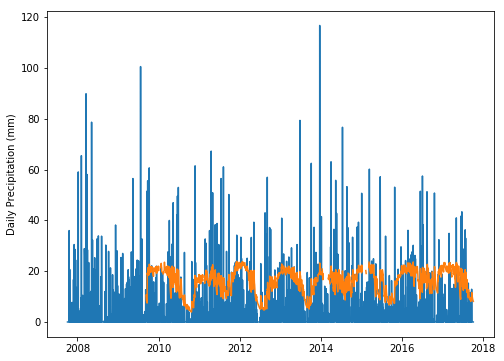

In [259]:
# Plot and examine data before moving too far in the code
plt.figure(figsize=(8,6))
plt.plot(df['LST_DATE'],df['P_DAILY_CALC'])
plt.plot(df['LST_DATE'],df['SOIL_MOISTURE_5_DAILY']*50) # volumetric water into mm
plt.ylabel('Daily Precipitation (mm)')
plt.show()

## Trim dates with no records

Years 2008 and 2009 years off the timeseries since they do not contain any soil moisture records.
Need to do this to be able to access elements by index number. Otherwise we will need to write something along these lines to access the first element: `df['LST_DATE'][730]` instead of `df['LST_DATE'][0]`

In [260]:
# Trim data and reset index
df = df[730:]
df = df.reset_index() 
df.head(5)

,index,WBANNO,LST_DATE,CRX_VN,LONGITUDE,LATITUDE,T_DAILY_MAX,T_DAILY_MIN,T_DAILY_MEAN,T_DAILY_AVG,...,SOIL_MOISTURE_5_DAILY,SOIL_MOISTURE_10_DAILY,SOIL_MOISTURE_20_DAILY,SOIL_MOISTURE_50_DAILY,SOIL_MOISTURE_100_DAILY,SOIL_TEMP_5_DAILY,SOIL_TEMP_10_DAILY,SOIL_TEMP_20_DAILY,SOIL_TEMP_50_DAILY,SOIL_TEMP_100_DAILY
0,730,63898,2009-10-02,2.402,-86.57,38.89,17.9,12.2,15.0,15.0,...,0.412,0.382,0.381,0.427,0.456,15.6,15.7,16.0,17.1,18.3
1,731,63898,2009-10-03,2.402,-86.57,38.89,13.8,9.7,11.7,12.1,...,0.393,0.369,0.378,0.427,0.456,14.8,15.2,15.7,16.9,18.1
2,732,63898,2009-10-04,2.402,-86.57,38.89,17.0,6.0,11.5,11.4,...,0.381,0.360,0.373,0.423,0.457,14.2,14.6,15.1,16.6,17.9
3,733,63898,2009-10-05,2.402,-86.57,38.89,19.4,4.5,12.0,11.5,...,0.370,0.352,0.368,0.419,0.456,13.8,14.2,14.7,16.3,17.6
4,734,63898,2009-10-06,2.402,-86.57,38.89,17.3,7.6,12.4,13.6,...,0.389,0.361,0.367,0.417,0.456,14.0,14.2,14.6,16.0,17.4


## Convert volumetric water content to millimeters

We will calculate the total amount of water in the top 50 cm of the soil profile using information from the soil moisture sensors at 5, 10, 20, and 50 cm depth. The resulting soil water content will be the weighted sum of all the layers between sensors. For instance, the soil water content in the layer 0-5 cm will be assumed equal to the soil water content of the sensor at 5 cm. This is because we don't have a sensor at the surface. We know that the soil moisture near the surface may be lower or higher, but this is the best we can do at this point. Similarly the soil water content in the layer 5-10 cm is approximated as the average of the sensor at 5 and 10 cm. To work in millimeters we simply multiply the volumetric water content reading of the sensor times the depth of the soil layer also expressed in millimeters. If we then add the millimeters from all four layers we end up with an estimate of the amount of millimeters of soil water in the top 50 cm of the soil profile.

In [261]:
# Calcualte soil moisture in the top 50 cm. 
swc_50cm_obs = df['SOIL_MOISTURE_5_DAILY'] * 50 + \
              (df['SOIL_MOISTURE_5_DAILY'] + df['SOIL_MOISTURE_10_DAILY'])/2 * 50 + \
              (df['SOIL_MOISTURE_10_DAILY'] + df['SOIL_MOISTURE_20_DAILY'])/2 * 100 + \
              (df['SOIL_MOISTURE_20_DAILY'] + df['SOIL_MOISTURE_50_DAILY'])/2 * 300

# Check for NaNs
# np.sum(np.isnan(swc_50cm_obs))

# Replace NaNs using backward fill
swc_50cm_obs = swc_50cm_obs.replace(np.nan,method='bfill')

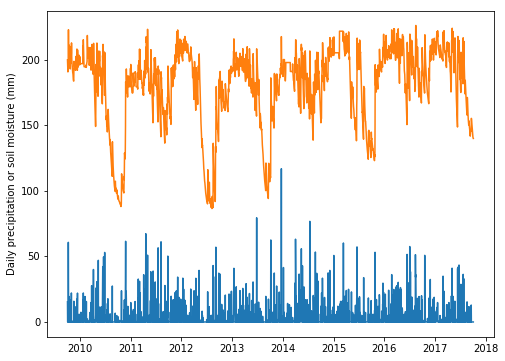

In [262]:
plt.figure(figsize=(8,6))
plt.plot(df['LST_DATE'],df['P_DAILY_CALC'])
plt.plot(df['LST_DATE'],swc_50cm_obs)
plt.ylabel('Daily precipitation or soil moisture (mm)')
plt.show()

In [263]:
# Define gamma model
gamma_model = lambda doy,C,phi: C + (0.99 - C)*np.sin(2*np.pi*(doy - phi)/365 + np.pi/2)


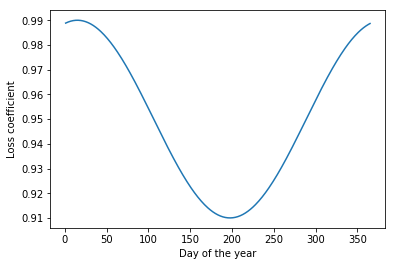

In [264]:
# Plot gamma model for days of the year 1 to 365 to ensure the model works as expected
plt.plot(np.arange(1,366),gamma_model(np.arange(1,366),0.95,15))
plt.xlabel('Day of the year')
plt.ylabel('Loss coefficient')
plt.show()


## Optimizing API parameters

We will pass in a dictionary called `X` the `x` variable (in this case DOY) and all the paramters that we know and we don't want to optimize (e.g. ul and ll). If we measured or know the value of some parameters it is a good practice to provide this infromation to the model. We assume that observations are more accurate than the optimized value.

Our function has two timeseries as input (`precipitation` and `day of the year`) and three scalars (`upperLimit`, `lowerLimit`, and `initialConditions`)

In [265]:
# Create function containing both the API and the gamma model so that we can optimize the
# function parameters

def api_model(X,C,phi):

    gamma_model = lambda x,C,phi: C + (0.99 - C)*np.sin(2*np.pi*(x - phi)/365 + np.pi/2)
    gamma = gamma_model(X['doy'],C,phi)
    
    api = [X['initialConditions']]
    for i in range(1,len(X['doy'])):
        current_api = np.minimum(X['lowerLimit'] + (api[i-1] - X['lowerLimit']) * gamma[i] + X['rainfall'][i],
                                 X['upperLimit']);
        api.append(current_api)
    
    return api
    

In [266]:
# Set function inputs
X = {'doy': df['LST_DATE'].dt.dayofyear, 
     'rainfall':df['P_DAILY_CALC'], 
     'upperLimit':np.max(swc_50cm_obs), 
     'lowerLimit':np.min(swc_50cm_obs),
     'initialConditions': (np.max(swc_50cm_obs) + np.min(swc_50cm_obs))/2}


## Guessing parameters values

This steps is not needed, but I want to show you that when parameters have clear physical meaning

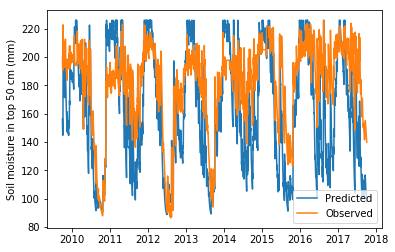

In [267]:
# Plot model with guessed values
C_guessed = 0.95
phi_guessed = 15.0
plt.plot(df['LST_DATE'],api_model(X,C_guessed, phi_guessed),label='Predicted')
plt.plot(df['LST_DATE'],swc_50cm_obs,label='Observed')
plt.ylabel('Soil moisture in top 50 cm (mm)')
plt.legend()
plt.show()


## Optimize parameters


In [268]:
# Optimize parameters
par_opt, par_cov = curve_fit(api_model, X, swc_50cm_obs)
print('Annual mean gamma value is',round(par_opt[0],2))
print('Day of the year with the lowest atmospheric demand is',round(par_opt[1]))


Annual mean gamma value is 0.97
Day of the year with the lowest atmospheric demand is 11.0


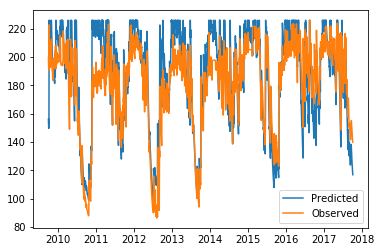

In [269]:
# Compare observed versus predicted timeries with OPTIMIZED parameters
swc_50cm_pred = api_model(X,par_opt[0],par_opt[1])
plt.plot(df['LST_DATE'], swc_50cm_pred, label='Predicted')
plt.plot(df['LST_DATE'], swc_50cm_obs, label='Observed')
plt.legend()
plt.show()


## Compute error metrics

For simplicity I will use the root mean squared error (RMSE) and median absolute error (MAE)

In [270]:
RMSE = np.sqrt(np.mean((swc_50cm_obs - swc_50cm_pred)**2))
print('RMSE =', round(RMSE,2),'mm')

MAE = np.median(np.abs(swc_50cm_obs - swc_50cm_pred))
print('MAE =', round(MAE,2),'mm')

RMSE = 16.62 mm
MAE = 11.7 mm


## Comments

- THe model is not too bad considering that we are only using rainfall and few extra parameters to keep the model within realistic boundaries (i.e. between zero moisture and saturation).

- You can try to compute the error metrics for the model with guessed parameters

- You can try to compute the soil moisture for a different depth from the soil surface.

## References

Saxton, K.E. and Lenz, A.T., 1967. Antecedent retention indexes predict soil moisture. Journal of the Hydraulics Division.

Crow, W.T. and Ryu, D., 2009. A new data assimilation approach for improving runoff prediction using remotely-sensed soil moisture retrievals. Hydrology and Earth System Sciences, 13(1), pp.1-16.